In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Load the data into a DataFrame
df = pd.read_csv("./output/validation_results_all.bed", sep="\t", header=None)

# Columns: chromosome, start, end, cell_line, label, score
df.columns = ["chromosome", "start", "end", "cell_line", "label", "score"]

# Remove the 'tensor()' part from 'start' and 'end' columns
df['start'] = df['start'].str.extract(r'tensor\((\d+)\)').astype(int)
df['end'] = df['end'].str.extract(r'tensor\((\d+)\)').astype(int)

df.head()

,chromosome,start,end,cell_line,label,score
0,chr1,9978,10253,22Rv1,Positive,0.889829
1,chr1,9997,10466,C4-2,Positive,1.810776
2,chr1,10001,10433,22Rv1,Positive,1.132296
3,chr1,10007,11313,PC-3,Positive,2.246324
4,chr1,10007,11318,LNCAP,Positive,1.379589


In [54]:
df['classified_label'] = df['score'].apply(lambda x: 'Positive' if x > 0.5 else 'Negative')

df

,chromosome,start,end,cell_line,label,score,classified_label
0,chr1,9978,10253,22Rv1,Positive,0.889829,Positive
1,chr1,9997,10466,C4-2,Positive,1.810776,Positive
2,chr1,10001,10433,22Rv1,Positive,1.132296,Positive
3,chr1,10007,11313,PC-3,Positive,2.246324,Positive
4,chr1,10007,11318,LNCAP,Positive,1.379589,Positive
...,...,...,...,...,...,...,...
169131,chrY,56680349,56680619,22Rv1,Positive,-1.795991,Negative
169132,chrY,56682074,56692430,C4-2,Positive,-4.298562,Negative
169133,chrY,56682855,56684506,LNCAP,Positive,-3.428779,Negative
169134,chrY,56690044,56691219,LNCAP,Positive,-3.138777,Negative


In [55]:
# Calculating accuracy: comparing the original label with the classified label
correct_predictions = (df['label'] == df['classified_label']).sum()
total_predictions = len(df)

accuracy = correct_predictions / total_predictions * 100

accuracy

86.66635133856778

In [56]:
# Splitting the dataset
below_05 = df[df['score'] < 0.5]
above_or_equal_05 = df[df['score'] >= 0.5]

# Calculating min and max for each part
min_below_05, max_below_05 = below_05['score'].min(), below_05['score'].max()
min_above_05, max_above_05 = above_or_equal_05['score'].min(), above_or_equal_05['score'].max()

# Define scaling functions
def scale_below_05(score):
    return (score - min_below_05) / (max_below_05 - min_below_05) * 0.5

def scale_above_05(score):
    return 0.5 * (score - min_above_05) / (max_above_05 - min_above_05) + 0.5

# Apply the scaling functions
df.loc[df['score'] < 0.5, 'scaled_score'] = df['score'].apply(scale_below_05)
df.loc[df['score'] >= 0.5, 'scaled_score'] = df['score'].apply(scale_above_05)

df

,chromosome,start,end,cell_line,label,score,classified_label,scaled_score
0,chr1,9978,10253,22Rv1,Positive,0.889829,Positive,0.516718
1,chr1,9997,10466,C4-2,Positive,1.810776,Positive,0.556218
2,chr1,10001,10433,22Rv1,Positive,1.132296,Positive,0.527117
3,chr1,10007,11313,PC-3,Positive,2.246324,Positive,0.574898
4,chr1,10007,11318,LNCAP,Positive,1.379589,Positive,0.537724
...,...,...,...,...,...,...,...,...
169131,chrY,56680349,56680619,22Rv1,Positive,-1.795991,Negative,0.435758
169132,chrY,56682074,56692430,C4-2,Positive,-4.298562,Negative,0.365727
169133,chrY,56682855,56684506,LNCAP,Positive,-3.428779,Negative,0.390067
169134,chrY,56690044,56691219,LNCAP,Positive,-3.138777,Negative,0.398182


In [57]:
import pandas as pd
import numpy as np

def calculate_mcc(TP, FP, FN, TN):
    # Calculate MCC, handling the case where the denominator is zero
    denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    if denominator == 0:
        return 0
    else:
        return (TP * TN - FP * FN) / denominator

def calculate_metrics(group):
    TP = ((group['label'] == 'Positive') & (group['classified_label'] == 'Positive')).sum()
    FP = ((group['label'] == 'Negative') & (group['classified_label'] == 'Positive')).sum()
    FN = ((group['label'] == 'Positive') & (group['classified_label'] == 'Negative')).sum()
    TN = ((group['label'] == 'Negative') & (group['classified_label'] == 'Negative')).sum()

    return TP, FP, FN, TN

# Apply the function to each cell line and calculate metrics
metrics = df.groupby('cell_line').apply(lambda group: pd.Series(calculate_metrics(group), index=['TP', 'FP', 'FN', 'TN']))

# Add a row for total
total_metrics = metrics.sum()
metrics.loc['Total'] = total_metrics

# Calculate Precision, Recall, FDR, and MCC for each row
metrics['Accuracy'] = (metrics['TP'] + metrics['TN']) / (metrics['TP'] + metrics['TN'] + metrics['FP'] + metrics['FN'])
metrics['Precision'] = metrics['TP'] / (metrics['TP'] + metrics['FP'])
metrics['Recall'] = metrics['TP'] / (metrics['TP'] + metrics['FN'])
metrics['FDR'] = metrics['FP'] / (metrics['FP'] + metrics['TP'])
metrics['MCC'] = metrics.apply(lambda row: calculate_mcc(row['TP'], row['FP'], row['FN'], row['TN']), axis=1)


print(metrics)


              TP    FP     FN     TN  Accuracy  Precision    Recall       FDR  \
cell_line                                                                       
22Rv1      39026  2454   2545  39555  0.940189   0.940839  0.938779  0.059161   
A549          42     7     81    142  0.676471   0.857143  0.341463  0.142857   
C4-2       12054  2086   2055  12054  0.853411   0.852475  0.854348  0.147525   
LNCAP      18801  4687   8062  22236  0.762968   0.800451  0.699885  0.199549   
MCF7         714    63    190    864  0.861824   0.918919  0.789823  0.081081   
PC-3         123    36    139    277  0.695652   0.773585  0.469466  0.226415   
THP-1        304    47    100    392  0.825623   0.866097  0.752475  0.133903   
Total      71064  9380  13172  75520  0.866664   0.883397  0.843630  0.116603   

                MCC  
cell_line            
22Rv1      0.880376  
A549       0.381379  
C4-2       0.706824  
LNCAP      0.530061  
MCF7       0.730209  
PC-3       0.394668  
THP-1      0.

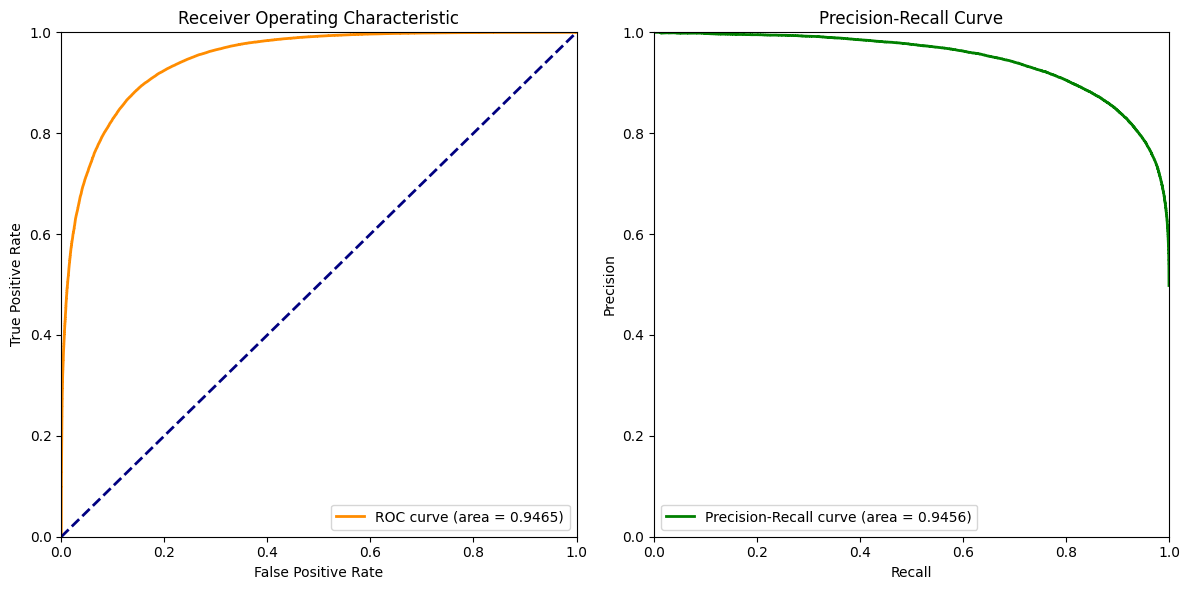

In [58]:

# Convert the 'label' column to binary format: 'Positive' to 1, 'Negative' to 0
df['binary_label'] = df['label'].map({'Positive': 1, 'Negative': 0})

# Use the scaled scores and true labels
y_true = df['binary_label']
y_scores = df['scaled_score']


# Compute Precision-Recall curve and area
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Plotting both ROC and Precision-Recall curves
plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.xlim([0.0, 1.0])  # Usually, this would be [0.0, 1.0]
plt.ylim([0.0, 1.0])

plt.tight_layout()
plt.show()

In [59]:
df

,chromosome,start,end,cell_line,label,score,classified_label,scaled_score,binary_label
0,chr1,9978,10253,22Rv1,Positive,0.889829,Positive,0.516718,1
1,chr1,9997,10466,C4-2,Positive,1.810776,Positive,0.556218,1
2,chr1,10001,10433,22Rv1,Positive,1.132296,Positive,0.527117,1
3,chr1,10007,11313,PC-3,Positive,2.246324,Positive,0.574898,1
4,chr1,10007,11318,LNCAP,Positive,1.379589,Positive,0.537724,1
...,...,...,...,...,...,...,...,...,...
169131,chrY,56680349,56680619,22Rv1,Positive,-1.795991,Negative,0.435758,1
169132,chrY,56682074,56692430,C4-2,Positive,-4.298562,Negative,0.365727,1
169133,chrY,56682855,56684506,LNCAP,Positive,-3.428779,Negative,0.390067,1
169134,chrY,56690044,56691219,LNCAP,Positive,-3.138777,Negative,0.398182,1


In [60]:
# Path for the output BED file
output_bed_path = "processed_bed_file.bed"

# Writing the DataFrame to a BED file, excluding the 'classified_label' column
df.to_csv(output_bed_path, sep='\t', index=False, header=False)

In [61]:


# Load the data into a DataFrame
df = pd.read_csv("./output/LNCaP_processed_overlap_const_active_v2.bed", sep="\t", header=None)

# Columns: chromosome, start, end, cell_line, label, score
df.columns = ["chromosome", "start", "end", "cell_line", "label", "score", "classified_label","scaled_score", "binary_label"]
	
# Get number of negative and number of positive labels
num_negative = (df['classified_label'] == 'Negative').sum()
num_positive = (df['classified_label'] == 'Positive').sum()
total_num = len(df)
num_positive/total_num

0.8864142538975501